In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# import functions_used as func

In [23]:
file_train = "~/ds/proj3/tanzania-water-wells/data/raw/training-set-values.csv" #x_train, training set values data
file_target_train = "~/ds/proj3/tanzania-water-wells/data/raw/training-labels.csv" #y_train, training set labels
file_test = "~/ds/proj3/tanzania-water-wells/data/raw/test-set.csv" #x_test, test set data

In [24]:
features = pd.read_csv(file_train)
targets = pd.read_csv(file_target_train)
X_test = pd.read_csv(file_test)

## Functions 

In [27]:
def model_preprocessing(df, feature_list, ohe, train=True):
    print('Beginning numerical cleaning...')
    df = numerical_clean(df, feature_list)
    print('Completed numerical cleaning.\n')
    
    print('Removing the target from the cleaned data frame...')
    target = df['status_group']
    print("---Length of target: ", len(target))
    df = df.drop(columns='status_group', axis = 1)
    print("---Shape of dataframe: ", df.shape)
    
    print("Reading the remaining columns as independent features\n")
    obj_list = obj_lister(df)
    
    print('Begining "object" cleaning...')
    ohe_df = obj_preprocessing(df, obj_list, ohe, train)
    print("---Shape of ohe_df: ", ohe_df.shape)
    print('...ending "object" cleaning.')
    
    print("Joining the cleaned numerical and object dataframes together.")
    # dropping the independent features from X
    df = df.drop(obj_list, axis=1)
    # joining the OHE dataframe to X
    model_df = df.join(ohe_df)
    print('Returning the main (independent features, X) and target (y) data frames...')
    return model_df, target


def numerical_clean(df, feature_list):
    #this takes the df and the list of numerical features to clean
    df = df[feature_list]
    print("check: df shape = ", df.shape)
    print('---Dropping 0 longitudes...')
    df = drop_zero_long(df)
    print("check: df shape = ", df.shape)
    print("---Replace 0's with average constructor year...")
    df = con_year_avg(df)
    print("check: df shape = ", df.shape)
    print('...returning a cleaned dataframe of numerical values.')
    return df

def drop_zero_long(df):
    return df.drop(df[df.longitude==0].index)

def con_year_avg(df):
    con_year_nonzero = df.replace(0, np.nan)
    avg_con_years = pd.DataFrame(con_year_nonzero.groupby(['extraction_type']).mean()['construction_year'])
    df = df.join(avg_con_years, rsuffix = '_avg', on = 'extraction_type')
    df = df.reset_index()
    df = df.drop(['index'], axis = 1)
#     df['construction_year'] = df.apply(con_year, axis=1)
#     df = df.drop(df[df['construction_year'].isna()].index)
#     print(df.shape)
#     df = df.drop(['construction_year_avg'], axis = 1)
#     print(df.shape)
#     df['construction_year'] = df['construction_year'].astype('int64')
    return df

def con_year(row: pd.DataFrame):
        ## This function replaces 
        if not row['construction_year']:
            return row['construction_year_avg']
        else:
            return row['construction_year']
            

def obj_lister(df):
    # returns a list of columns that contain Objects
    obj_list = []
    for col in df.select_dtypes([np.object]):
        obj_list.append(col)
    return obj_list

def obj_preprocessing(df, obj_list, ohe, train = True):
    '''
    
    '''
    df_current = df[obj_list]
    # Clean the df if there are NaNs
    df = NaN_cleaning(df_current)
    #OHE data
    array_current = ohe_data(df, ohe, train)
    #return a dataframe of the OHE data
    return pd.DataFrame(array_current)


def NaN_cleaning(df):
    # Replace NaN with "unknown" bin
    print('---Replacing NaN with "unknown" bin...')
    df = df.replace(np.nan, 'unknown')
    print(f'---Check: Number of rows with nulls: {len(df[df.isna().any(axis=1)])}...\n')
    return df.reset_index(drop=True)

def ohe_data(df, ohe, train):
    #OHE the data
    print('Begin one hot encoding data...')
    if train:
        array_current = ohe.fit_transform(df).toarray()
    else:
        array_current = ohe.transform(df).toarray()
    print('Finish one hot encoding data...\n')
    return array_current


# Function to calculate accuracy 
# from: https://www.geeksforgeeks.org/decision-tree-implementation-python/
def calc_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
    confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
  


## Model 1: Decision Tree; Gini criterion

In [28]:
#note the target is listed in here

features_list = ['basin', 'region', 'scheme_management', 'scheme_name',
       'extraction_type', 'management', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type','gps_height', 'longitude', 'latitude', 
       'region_code', 'district_code', 'construction_year', 'status_group']   


In [29]:
ohe = OneHotEncoder(handle_unknown = 'ignore')

- Perform a train test split of the "training data" given in the problem. 
- Join the training data (X and y) together.


In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42)
joined_train = X_train.join(y_train, lsuffix='_l', rsuffix='_r')

- Perform the pre-processing. Clean the numerical data. Perform One Hot Encoding.

In [31]:
joined_train_processed, y_train = model_preprocessing(joined_train, features_list, ohe, train = True)

Beginning numerical cleaning...
check: df shape =  (44550, 18)
---Dropping 0 longitudes...
check: df shape =  (43211, 18)
---Replace 0's with average constructor year...
check: df shape =  (43211, 19)
...returning a cleaned dataframe of numerical values.
Completed numerical cleaning.

Removing the target from the cleaned data frame...
---Length of target:  43211
---Shape of dataframe:  (43211, 18)
Reading the remaining columns as independent features

Begining "object" cleaning...
---Replacing NaN with "unknown" bin...
---Check: Number of rows with nulls: 0...

Begin one hot encoding data...
Finish one hot encoding data...

---Shape of ohe_df:  (43211, 2572)
...ending "object" cleaning.
Joining the cleaned numerical and object dataframes together.
Returning the main (independent features, X) and target (y) data frames...


- Train the decision tree with training data.

In [38]:
joined_train_processed.iloc[joined_train_processed.isna().index]

gps_height  longitude   latitude  region_code  district_code  \
0             330  38.123839  -6.087137            6              1   
1               0  33.312321  -2.814100           19              4   
2            1542  34.783049  -4.842093           13              4   
3             523  34.660944 -10.707331           10              3   
4            1332  36.701671  -2.737807            2              6   
...           ...        ...        ...          ...            ...   
43206         327  36.367112  -8.774761            5              4   
43207        1743  34.531524  -9.769604           11              5   
43208         -13  38.974416  -5.420823            4              5   
43209           0  34.316586  -3.107161           17              6   
43210        1290  37.626401  -3.211457            3              1   

       construction_year  construction_year_avg    0    1    2  ...  2562  \
0                   1972            1999.626156  0.0  0.0  0.0  ...   0.0   
1                      0            2001.171001  0.0  0.0  0.0  ...   0.0   
2                   2010            1995.925998  1.0  0.0  0.0  ...   0.0   
3                   2013            1995.925998  0.0  1.0  0.0  ...   0.0   
4                   2011            1995.925998  1.0  0.0  0.0  ...   0.0   
...                  ...                    ...  ...  ...  ...  ...   ...   
43206               1995            1995.925998  0.0  0.0  0.0  ...   0.0   
43207               1988            1995.925998  0.0  1.0  0.0  ...   0.0   
43208               2005            1993.172512  0.0  0.0  0.0  ...   1.0   
43209                  0            1999.357409  0.0  0.0  0.0  ...   1.0   
43210               1976            1995.925998  0.0  0.0  0.0  ...   0.0   

       2563  2564  2565  2566  2567  2568  2569  2570  2571  
0       0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
1       0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
2       0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
3       1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
4       1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
43206   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
43207   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
43208   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
43209   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
43210   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  

[43211 rows x 2579 columns]

In [32]:
dtc = DecisionTreeClassifier(random_state=42, max_depth=5) 
dtc.fit(joined_train_processed, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

- Repeat the pre-processing on the test data.
- Join the testing data (X and y) together.

In [50]:
joined_test = X_test.join(y_test, lsuffix='_l', rsuffix='_r')

- Preprocess the testing data.

In [51]:
joined_test_processed, y_test = model_preprocessing(joined_test, features_list, ohe, train=False)

Beginning numerical cleaning...
check: df shape =  (14850, 18)
---Dropping 0 longitudes...
check: df shape =  (14377, 18)
---Replace 0's with average constructor year...
check: df shape =  (14377, 18)
...returning a cleaned dataframe of numerical values.
Completed numerical cleaning.

Removing the target from the cleaned data frame...
---Length of target:  14377
---Shape of dataframe:  (14377, 17)
Reading the remaining columns as independent features

Begining "object" cleaning...
---Replacing NaN with "unknown" bin...
---Check: Number of rows with nulls: 0...

Begin one hot encoding data...
Finish one hot encoding data...

---Shape of ohe_df:  (14377, 2572)
...ending "object" cleaning.
Joining the cleaned numerical and object dataframes together.
Returning the main (independent features, X) and target (y) data frames...


- Make predictions with the test data.

In [52]:
predicts = dtc.predict(joined_test_processed)

- Check the score of the model.

In [53]:
dtc.score(joined_test_processed, y_test) #x_test, y_test from split

0.7052931766015164

In [26]:
calc_accuracy(y_test, predicts)

Confusion Matrix:  [[7426   39  397]
 [ 807   86   94]
 [2848   52 2628]]
Accuracy :  70.52931766015163
Report :                           precision    recall  f1-score   support

             functional       0.67      0.94      0.78      7862
functional needs repair       0.49      0.09      0.15       987
         non functional       0.84      0.48      0.61      5528

               accuracy                           0.71     14377
              macro avg       0.67      0.50      0.51     14377
           weighted avg       0.72      0.71      0.67     14377



In [54]:
calc_accuracy(y_test, predicts)

Confusion Matrix:  [[7426   39  397]
 [ 807   86   94]
 [2848   52 2628]]
Accuracy :  70.52931766015163
Report :                           precision    recall  f1-score   support

             functional       0.67      0.94      0.78      7862
functional needs repair       0.49      0.09      0.15       987
         non functional       0.84      0.48      0.61      5528

               accuracy                           0.71     14377
              macro avg       0.67      0.50      0.51     14377
           weighted avg       0.72      0.71      0.67     14377



- Let's visualize this


In [58]:
joined_train_processed.columns


Index([       'gps_height',         'longitude',          'latitude',
             'region_code',     'district_code',        'population',
       'construction_year',                   0,                   1,
                         2,
       ...
                      2562,                2563,                2564,
                      2565,                2566,                2567,
                      2568,                2569,                2570,
                      2571],
      dtype='object', length=2579)

In [55]:
# need to begin with numerical feature names
feature_names = ['gps_height', 'longitude', 'latitude',
                'region_code', 'district_code',
                 'construction_year']
for name in ohe.categories_:
    for i in name:
        numerical_feature_names.append(i)

NameError: name 'numerical_feature_names' is not defined

In [60]:
n_nodes = dtc.tree_.node_count
children_left = dtc.tree_.children_left
children_right = dtc.tree_.children_right
feature = dtc.tree_.feature
threshold = dtc.tree_.threshold

# This code courtesy of sklearn:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 numerical_feature_names[int(feature[i])],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 61 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, dry] <= 0.5 else to node 32.
	node=1 test node: go to node 2 if X[:, other] <= 0.5 else to node 17.
		node=2 test node: go to node 3 if X[:, communal standpipe multiple] <= 0.5 else to node 10.
			node=3 test node: go to node 4 if X[:, never pay] <= 0.5 else to node 7.
				node=4 test node: go to node 5 if X[:, Iringa] <= 0.5 else to node 6.
					node=5 leaf node.
					node=6 leaf node.
				node=7 test node: go to node 8 if X[:, Lake Nyasa] <= 0.5 else to node 9.
					node=8 leaf node.
					node=9 leaf node.
			node=10 test node: go to node 11 if X[:, longitude] <= 30.4269437789917 else to node 14.
				node=11 test node: go to node 12 if X[:, construction_year] <= 1990.5 else to node 13.
					node=12 leaf node.
					node=13 leaf node.
				node=14 test node: go to node 15 if X[:, pay per bucket] <= 0.5 else to node 16.
					node=15 leaf node.
					node=16 leaf node.
		node

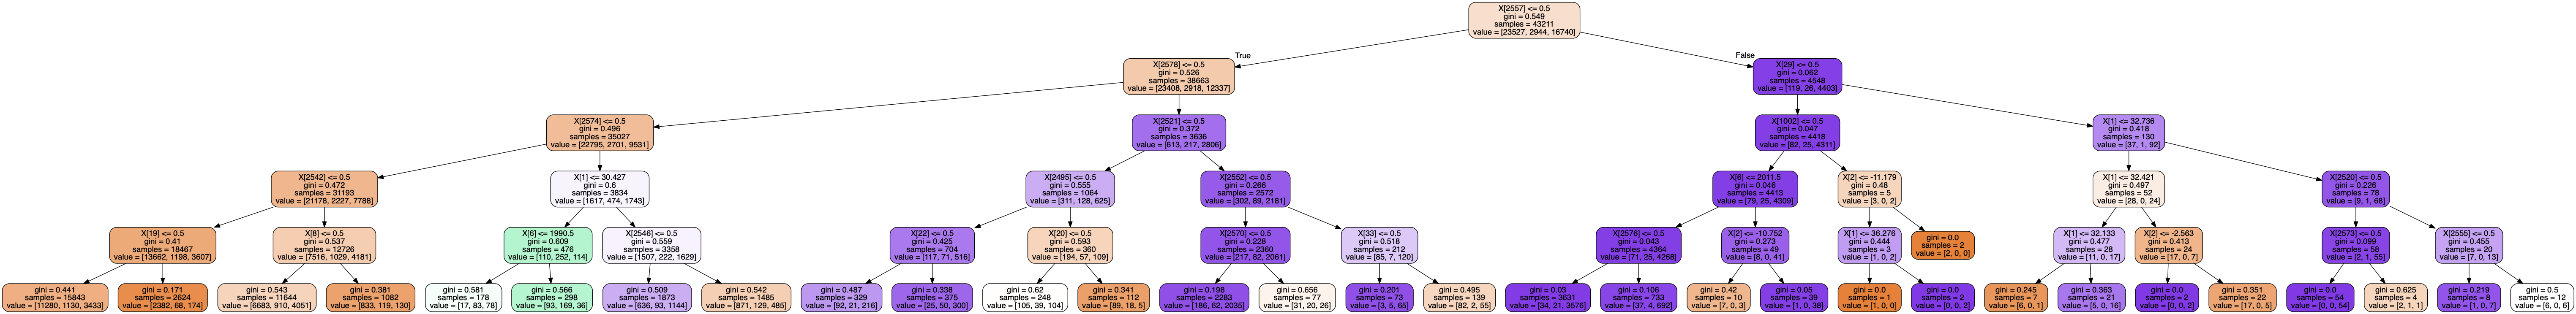

In [62]:
dot_file = StringIO()

export_graphviz(dtc, out_file=dot_file, filled=True,
               rounded=True)

image=pydotplus.graph_from_dot_data(dot_file.getvalue())
Image(image.create_png())

In [80]:
numerical_feature_names[19]

'Iringa'

## Model #2

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 6, 10]
}
rfc = RandomForestClassifier(n_estimators=10, random_state=1, bootstrap=True)
gs = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

In [64]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, max_depth = 50, random_state=42, bootstrap=True, class_weight='balanced')

In [65]:
rfc.fit(joined_train_processed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [66]:
predicts = rfc.predict(joined_test_processed)

In [67]:
rfc.score(joined_test_processed, y_test)

0.7920984906447799

In [69]:
calc_accuracy(y_test,predicts)

Confusion Matrix:  [[6762  261  839]
 [ 471  358  158]
 [1122  138 4268]]
Accuracy :  79.209849064478
Report :                           precision    recall  f1-score   support

             functional       0.81      0.86      0.83      7862
functional needs repair       0.47      0.36      0.41       987
         non functional       0.81      0.77      0.79      5528

               accuracy                           0.79     14377
              macro avg       0.70      0.66      0.68     14377
           weighted avg       0.79      0.79      0.79     14377



# Model 3 - KNN

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean as euc
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
# from visualize import generate_moons_df, preprocess, plot_boundaries

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(0)

In [17]:
features_list = ['basin', 'region', 'scheme_management', 'scheme_name',
       'extraction_type', 'management', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type','gps_height', 'longitude', 'latitude', 
       'region_code', 'district_code', 'population', 'construction_year', 'status_group']   


In [29]:
scaler = StandardScaler()
scaler.fit(joined_train_processed)
X_train_scaled = scaler.transform(joined_train_processed)
X_test_scaled = scaler.transform(joined_test_processed)

In [28]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(joined_train_processed, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
knn.fit(X_train_scaled,y_train)
sk_preds = knn.predict(X_test_scaled)

In [35]:
knn.score(X_test_scaled,y_test)

0.7651109410864575

In [36]:
calc_accuracy(y_test,sk_preds)

Confusion Matrix:  [[6649  242  971]
 [ 515  301  171]
 [1361  117 4050]]
Accuracy :  76.51109410864575
Report :                           precision    recall  f1-score   support

             functional       0.78      0.85      0.81      7862
functional needs repair       0.46      0.30      0.37       987
         non functional       0.78      0.73      0.76      5528

               accuracy                           0.77     14377
              macro avg       0.67      0.63      0.64     14377
           weighted avg       0.76      0.77      0.76     14377



# Model 4 - Multinomial Logistic Regression

In [73]:
logreg = LogisticRegression(solver='newton-cg', max_iter=10, random_state=42, multi_class = 'multinomial')

logreg.fit(joined_train_processed, y_train)

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
confusion_matrix(y_test, logreg.predict(joined_test_processed))

array([[7257,    0,  605],
       [ 871,    0,  116],
       [3149,    0, 2379]])